In [1]:
# Load .env variables in environment

%reload_ext dotenv
%dotenv

In [2]:
import hopsworks
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

In [4]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/209044
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=3)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                             version=3,
                                             description="Read from Wine dataset",
                                             labels=["quality"],
                                             query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/209044/fs/208963/fv/wine/version/3


In [5]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.36s) 


In [6]:
X_train

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,is_white
0,5.9,0.20,0.23,1.5,0.037,38.0,93.0,0.99021,3.36,0.49,12.0,1
1,5.1,0.11,0.32,1.6,0.028,12.0,90.0,0.99008,3.57,0.52,12.2,1
2,8.2,0.18,0.49,1.1,0.033,28.0,81.0,0.99230,3.00,0.68,10.4,1
3,10.5,0.59,0.49,2.1,0.070,14.0,47.0,0.99910,3.30,0.56,9.6,0
5,7.6,0.48,0.28,10.4,0.049,57.0,205.0,0.99748,3.24,0.45,9.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5289,9.3,0.48,0.29,2.1,0.127,6.0,16.0,0.99680,3.22,0.72,11.2,0
5290,5.9,0.20,0.40,1.3,0.047,23.0,92.0,0.99232,3.20,0.45,10.0,1
5291,6.8,0.45,0.36,5.0,0.033,28.0,156.0,0.99100,3.11,0.40,12.4,1
5292,6.5,0.30,0.32,2.0,0.044,34.0,90.0,0.99185,3.37,0.68,11.0,1


In [7]:
y_train

,quality
0,1
1,1
2,2
3,0
5,0
...,...
5289,0
5290,1
5291,2
5292,2


## Model training

### Decision Tree 

In [22]:
clf = Pipeline([
    ('clf', DecisionTreeClassifier(random_state=101))])

# a list of dictionaries to specify the parameters that we'd want to tune
criterion = ['gini', 'entropy']
splitter = ['best']
max_depth = [8, 9, 10, 11]
min_samples_leaf = [2, 3, 5]
class_weight = ['balanced', None]

param_grid = \
    [{'clf__class_weight': class_weight
         , 'clf__criterion': criterion
         , 'clf__splitter': splitter
         , 'clf__max_depth': max_depth
         , 'clf__min_samples_leaf': min_samples_leaf
      }]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
DT = Pipeline([
    ('scl', StandardScaler()),
    ('gs', gs)
])

DT.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


Pipeline(steps=[('scl', StandardScaler()),
                ('gs',
                 GridSearchCV(cv=5,
                              estimator=Pipeline(steps=[('clf',
                                                         DecisionTreeClassifier(random_state=101))]),
                              n_jobs=-1,
                              param_grid=[{'clf__class_weight': ['balanced',
                                                                 None],
                                           'clf__criterion': ['gini',
                                                              'entropy'],
                                           'clf__max_depth': [8, 9, 10, 11],
                                           'clf__min_samples_leaf': [2, 3, 5],
                                           'clf__splitter': ['best']}],
                              scoring='accuracy', verbose=1))])

In [23]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = DT.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
results = confusion_matrix(y_test, y_pred)
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,2,accuracy,macro avg,weighted avg
precision,0.630372,0.494774,0.470588,0.536355,0.531911,0.538383
recall,0.578947,0.620087,0.289593,0.536355,0.496209,0.536355
f1-score,0.603567,0.550388,0.358543,0.536355,0.504166,0.529434
support,380.000000,458.000000,221.000000,0.536355,1059.000000,1059.000000


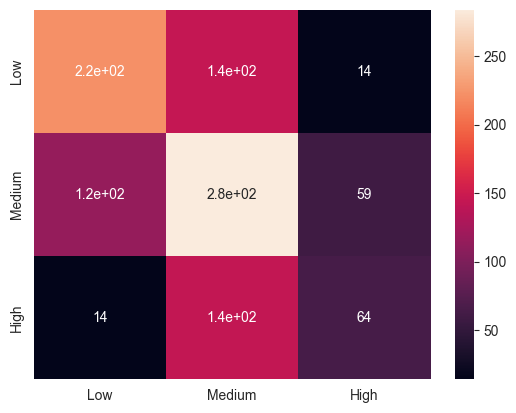

In [21]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ["Low", "Medium", "High"], columns=["Low", "Medium", "High"])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

### KNN Classifier

In [38]:
clf = Pipeline([
    ('clf', KNeighborsClassifier())
])

# a list of dictionaries to specify the parameters that we'd want to tune
n_neighbors = [1, 2, 3, 5, 8, 13]

param_grid = \
    [{
        'clf__n_neighbors': n_neighbors
    }]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
DT = Pipeline([
    ('scl', StandardScaler()),
    ('gs', gs)
])

DT.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Pipeline(steps=[('scl', StandardScaler()),
                ('gs',
                 GridSearchCV(cv=5,
                              estimator=Pipeline(steps=[('clf',
                                                         KNeighborsClassifier())]),
                              n_jobs=-1,
                              param_grid=[{'clf__n_neighbors': [1, 2, 3, 5, 8,
                                                                13]}],
                              scoring='accuracy', verbose=1))])

In [39]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = DT.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
results = confusion_matrix(y_test, y_pred)
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,2,accuracy,macro avg,weighted avg
precision,0.612732,0.515267,0.544304,0.554297,0.557434,0.556300
recall,0.607895,0.589520,0.389140,0.554297,0.528852,0.554297
f1-score,0.610304,0.549898,0.453826,0.554297,0.538009,0.551524
support,380.000000,458.000000,221.000000,0.554297,1059.000000,1059.000000


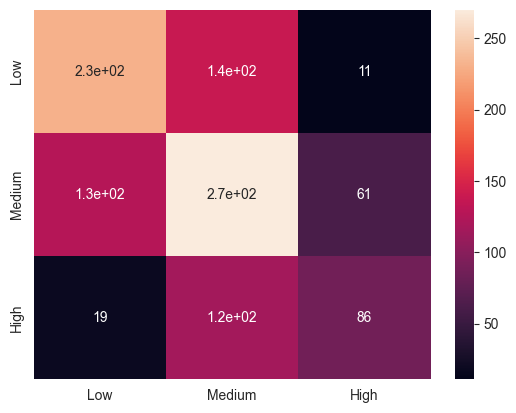

In [40]:
df_cm = pd.DataFrame(results, ["Low", "Medium", "High"], columns=["Low", "Medium", "High"])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

### SVM

In [47]:
clf = Pipeline([
    ('clf', SVC())
])

# a list of dictionaries to specify the parameters that we'd want to tune
c_values = [0.1, 0.25, 0.5, 0.75, 1]

param_grid = \
    [{
        'clf__C': c_values
    }]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
DT = Pipeline([
    ('scl', StandardScaler()),
    ('gs', gs)
])

DT.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


Pipeline(steps=[('scl', StandardScaler()),
                ('gs',
                 GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', SVC())]),
                              n_jobs=-1,
                              param_grid=[{'clf__C': [0.1, 0.25, 0.5, 0.75,
                                                      1]}],
                              scoring='accuracy', verbose=1))])

In [50]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = DT.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
results = confusion_matrix(y_test, y_pred)
metrics = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(metrics)

,0,1,2,accuracy,macro avg,weighted avg
precision,0.657825,0.523726,0.619469,0.581681,0.60034,0.591825
recall,0.652632,0.650655,0.316742,0.581681,0.54001,0.581681
f1-score,0.655218,0.580331,0.419162,0.581681,0.55157,0.573569
support,380.000000,458.000000,221.000000,0.581681,1059.00000,1059.000000


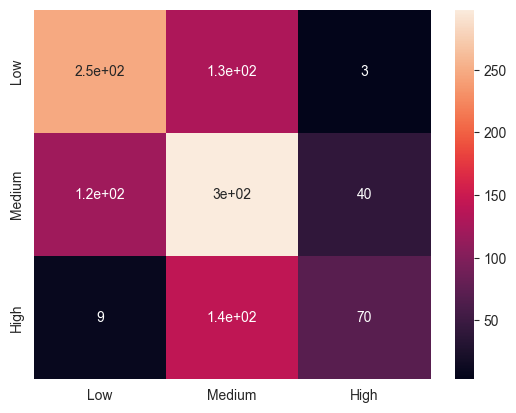

In [51]:
df_cm = pd.DataFrame(results, ["Low", "Medium", "High"], columns=["Low", "Medium", "High"])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

## Model upload to Hopsworks

In [52]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_model' directory will be saved to the model registry. Create the dir, first.
model_dir = "model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model",
    metrics={"accuracy": metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/209044/models/wine_model/1


Model(name: 'wine_model', version: 1)